# Exact Diagonalization of a 1D Spin Chain
<b> Christina Lee

Category: Grad

Prerequisites: Many-Body Quantum Mechanics, Part 1 </b>

Check out part 1 for the theory background.  Today is all programming.

Here we will initialize how many spins we will have in our chain.  

Remember to keep a reasonable number.  

Your number of states goes as $2^n$, and the size of your Hamiltonian will goes as $4^n$.  A 10-spin chain will already have over a million entries, before taking into account our tricks.

On my machine that has 16Gb of RAM and 3.2 GHz Intel i5 processor:

| n | m_z | t (min) | Memory (Gb) |
|---|-----|---------|-------------|
|16 | 8   | 1.5     | 2           |
|18 | 9   | ?       |  >16        |
|18 | 8   | 32.1    |   15.5      |

I included a file in this directory, ED.jl, that is the functional, rather than demonstrative, version of the code here.  For running large $n$, I recommend using that.  

In [121]:
using PyPlot

Here went enter one parameter `n`, the number of spins in our chain.

The parameter `nstates` is automatically calculated given `n`.


In [122]:
n=10
nstates=2^n

1024

First. let's write out all our possible states in the $S^z$ basis.

In [123]:
psi=collect(0:(nstates-1))
for p in psi
    println(bin(p,n),' ',p)
end

0000000000 0
0000000001 1
0000000010 2
0000000011 3
0000000100 4
0000000101 5
0000000110 6
0000000111 7
0000001000 8
0000001001 9
0000001010 10
0000001011 11
0000001100 12
0000001101 13
0000001110 14
0000001111 15
0000010000 16
0000010001 17
0000010010 18
0000010011 19
0000010100 20
0000010101 21
0000010110 22
0000010111 23
0000011000 24
0000011001 25
0000011010 26
0000011011 27
0000011100 28
0000011101 29
0000011110 30
0000011111 31
0000100000 32
0000100001 33
0000100010 34
0000100011 35
0000100100 36
0000100101 37
0000100110 38
0000100111 39
0000101000 40
0000101001 41
0000101010 42
0000101011 43
0000101100 44
0000101101 45
0000101110 46
0000101111 47
0000110000 48
0000110001 49
0000110010 50
0000110011 51
0000110100 52
0000110101 53
0000110110 54
0000110111 55
0000111000 56
0000111001 57
0000111010 58
0000111011 59
0000111100 60
0000111101 61
0000111110 62
0000111111 63
0001000000 64
0001000001 65
0001000010 66
0001000011 67
0001000100 68
0001000101 69
0001000110 70
0001000111 71
00

As in Part 1, we will be using the powers of 2 and the masks I described to perform operations on numbers.  So we don't have to calculate them each time, we just store them in memory.

In [124]:
powers2=collect(0:(n-1));
powers2=2.^powers2;

mask=[0;powers2]+[powers2;0];
mask=[mask[2:end-1];[1+2^(n-1)]]
for m in mask
    println(bin(m,n))
end

0000000011
0000000110
0000001100
0000011000
0000110000
0001100000
0011000000
0110000000
1100000000
1000000001


`m` will be an array that will store the magnetization of each state.   See Part 1 for more explanation of how this works.  

In Part 1, I just talked about counting the number of up-spins as magnetization.   That's not true.  An up-spin is $+1/2$ and a down-spin is $-1/2$.  So we have to just modify our magnetization a little.

In [125]:
m=zeros(psi)
for i in 1:nstates
    m[i]=sum((psi[i]&powers2)./(powers2))
end
m=(m-n/2)/2

1024-element Array{Float64,1}:
 -2.5
 -2.0
 -2.0
 -1.5
 -2.0
 -1.5
 -1.5
 -1.0
 -2.0
 -1.5
 -1.5
 -1.0
 -1.5
  ⋮  
  1.0
  1.5
  1.5
  2.0
  1.0
  1.5
  1.5
  2.0
  1.5
  2.0
  2.0
  2.5

# Grouped by Magnetization

Now that we have the magnetizations corresponding to each state, we perform the trickery that allows us to dramatically reduce the difficulty of our problem. 

Magnetization is a conserved quantity, so we know that the Hamiltonian is not going to mix states of different magnetizations.   So we only have to deal with one magnetization at a time, which is a much smaller problem.  

First, we are going to sort our states by magnetization.

In [126]:
ind=sortperm(m)
m=m[ind]
psi=psi[ind]
[psi m]

1024×2 Array{Float64,2}:
    0.0  -2.5
    1.0  -2.0
    2.0  -2.0
    4.0  -2.0
    8.0  -2.0
   16.0  -2.0
   32.0  -2.0
   64.0  -2.0
  128.0  -2.0
  256.0  -2.0
  512.0  -2.0
    3.0  -1.5
    5.0  -1.5
    ⋮        
 1020.0   1.5
  511.0   2.0
  767.0   2.0
  895.0   2.0
  959.0   2.0
  991.0   2.0
 1007.0   2.0
 1015.0   2.0
 1019.0   2.0
 1021.0   2.0
 1022.0   2.0
 1023.0   2.5

But even though they're now sorted, they're still mashed all together.  Now we want to pull them apart.

That's why we're are going to create an <b>Array of Arrays</b>.  Each elememt in `psia` will store all the states of a given magnetization.  

Why don't we just create a two dimensional array?

Because each element has a different length.  

The number of states at a given magnetization is given by a 

In [127]:
ma=collect(0:.5:n/2.)-n/4
    
psia=Array{Array{Int64}}(n+1)
first=1
last=1
for i in 1:(n+1)
    psia[i]=psi[first:last]
    
    #now we compute them for the next round
    first=last+1
    last=last+binomial(n,i)
end
psia

11-element Array{Array{Int64,N},1}:
 [0]                                                                                           
 [1,2,4,8,16,32,64,128,256,512]                                                                
 [3,5,6,9,10,12,17,18,20,24  …  384,513,514,516,520,528,544,576,640,768]                       
 [7,11,13,14,19,21,22,25,26,28  …  672,704,769,770,772,776,784,800,832,896]                    
 [15,23,27,29,30,39,43,45,46,51  …  840,848,864,897,898,900,904,912,928,960]                   
 [31,47,55,59,61,62,79,87,91,93  …  930,932,936,944,961,962,964,968,976,992]                   
 [63,95,111,119,123,125,126,159,175,183  …  972,977,978,980,984,993,994,996,1000,1008]         
 [127,191,223,239,247,251,253,254,319,351  …  995,997,998,1001,1002,1004,1009,1010,1012,1016]  
 [255,383,447,479,495,503,507,509,510,639  …  999,1003,1005,1006,1011,1013,1014,1017,1018,1020]
 [511,767,895,959,991,1007,1015,1019,1021,1022]                                                
 [10

In [173]:
mz=10

dim=binomial(n,mz-1)

#M=ma[i]*(ma[i]+1)*eye(Float64,dim,dim)
M=zeros(Float64,dim,dim);

In [174]:
Psi=psia[mz]
for p in Psi
    println(bin(p,n),' ',p)
end

0111111111 511
1011111111 767
1101111111 895
1110111111 959
1111011111 991
1111101111 1007
1111110111 1015
1111111011 1019
1111111101 1021
1111111110 1022


In [175]:
mp=sum(Psi[1]&powers2./powers2)

for ii in 1:length(Psi)
    p=Psi[ii]
    for jj in 1:n
        flipped=p$mask[jj]
        if sum((flipped&powers2)./powers2) == mp
            index=findstate(flipped,Psi)
            M[ii,index]=.5
            M[index,ii]=.5
            println(bin(p,n),'\t',bin(flipped,n))
        end
            
    end
end

0111111111	1011111111
0111111111	1111111110
1011111111	1101111111
1011111111	0111111111
1101111111	1110111111
1101111111	1011111111
1110111111	1111011111
1110111111	1101111111
1111011111	1111101111
1111011111	1110111111
1111101111	1111110111
1111101111	1111011111
1111110111	1111111011
1111110111	1111101111
1111111011	1111111101
1111111011	1111110111
1111111101	1111111110
1111111101	1111111011
1111111110	1111111101
1111111110	0111111111


In [53]:
M

1×1 Array{Float64,2}:
 0.0

In [176]:
eig10=eigvals(M)

10-element Array{Float64,1}:
 -1.0     
 -0.809017
 -0.809017
 -0.309017
 -0.309017
  0.309017
  0.309017
  0.809017
  0.809017
  1.0     

In [14]:
function findstate(state::Int,set::Array{Int})
    iimin=1
    iimax=length(set)
    
    if set[iimin] == state
        return iimin
    end
    if set[iimax] == state
        return iimax
    end
    
    
    found=false
    count=0
    
    while found==false && count < length(set)
        count+=1
        index=floor(Int,iimin+(iimax-iimin)/2)
        if state < set[index]
            iimax=index-1
        elseif state > set[index]
            iimin=index+1
        else
            found=true
            return index
        end
    end
    
    if found == false
        println("findstate never found a match")
        println("Are you sure the state is in that Array?")
    end
    
    return 0
end

findstate (generic function with 1 method)

In [17]:
v=eigvecs(M)

1×1 Array{Float64,2}:
 1.0

In [68]:
temp=v[:,1]

for ii in 1:length(temp)
    if temp[((0:(length(temp)-1))+ii)%length(temp)+1]==temp
        println(ii)
    end
end

5


In [37]:
((0:9)+2)%10+1

10-element Array{Int64,1}:
  3
  4
  5
  6
  7
  8
  9
 10
  1
  2

In [116]:
lambdap=eigvals(M)

792-element Array{Float64,1}:
 -3.52758
 -3.29351
 -3.08005
 -3.05244
 -2.8996 
 -2.83898
 -2.81837
 -2.76266
 -2.67717
 -2.65853
 -2.60491
 -2.60491
 -2.60491
  ⋮      
  2.60491
  2.60491
  2.65853
  2.67717
  2.76266
  2.81837
  2.83898
  2.8996 
  3.05244
  3.08005
  3.29351
  3.52758

In [120]:
length()

Array{Float64,1}

In [177]:
eigall=[eig1;eig2;eig3;eig4;eig5;eig6;eig7;eig8;eig9;eig10;eig11];

In [178]:
eigall=sort(eigall);

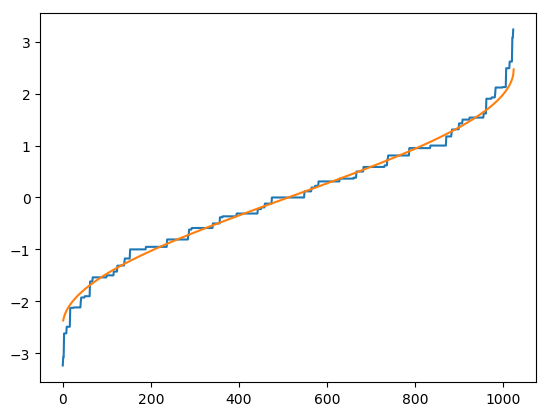

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001EFFA630>

In [179]:
plot(eigall)
xtemp=collect(1:length(eigall))
ytemp=(-acos(xtemp*2/length(eigall)-1)+pi/2)*pi/2
plot(xtemp,ytemp)

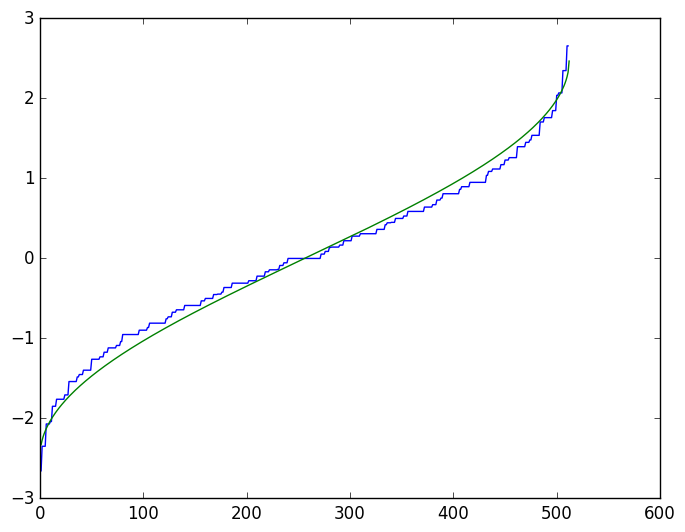

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fde0c43ac50>

In [99]:
plot(lambda)
xtemp=collect(1:length(lambda))
ytemp=(-acos(xtemp*2/length(lambda)-1)+pi/2)*pi/2
plot(xtemp,ytemp)

In [91]:
xtemp*2/length(lambda)-1

512-element Array{Float64,1}:
 -0.996094
 -0.992188
 -0.988281
 -0.984375
 -0.980469
 -0.976563
 -0.972656
 -0.96875 
 -0.964844
 -0.960938
 -0.957031
 -0.953125
 -0.949219
  ⋮       
  0.957031
  0.960938
  0.964844
  0.96875 
  0.972656
  0.976563
  0.980469
  0.984375
  0.988281
  0.992188
  0.996094
  1.0     